# Исследование базы данных StackOverFlow с информацией о постах за 2008 год

У нас есть версия базы данных StackOverFlow (сервис вопросов и ответов о программировании) c постами за 2008 год. Однако там есть информация об оценках за посты, полученные позже указанного срока.

База данных включает в себя 6 таблиц: 
- тstackoverflow.badges: информация о значках, которые присуждаются за разные достижения, 
- stackoverflow.post_types: информация о типе постов: вопрос или ответ,
- stackoverflow.users: информация о пользователях,
- stackoverflow.vote_types: информация о типах голосов,
- stackoverflow.votes: информация о голосах за посты,
- stackoverflow.posts: информация о постах. 

Цель проекта - проанализировать базу данных и ответить на вопросы, написав к ней запросы. 

#### Задача 1

Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [ ]:
SELECT COUNT(DISTINCT posts)
FROM stackoverflow.posts 
WHERE post_type_id = 1 
AND (score > 300 
      OR favorites_count >= 100);

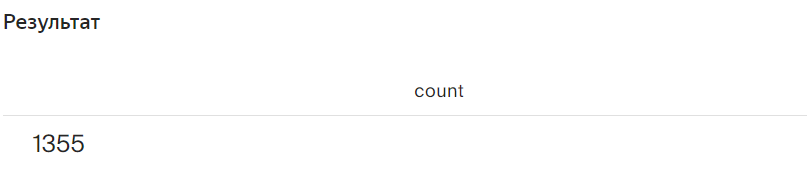

#### Задача 2

Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [ ]:
WITH ids AS (SELECT COUNT(id) as id_per_day,
             creation_date::date
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-18'
      AND post_type_id = 1
GROUP BY creation_date::date)
SELECT ROUND(AVG(id_per_day))
FROM ids;

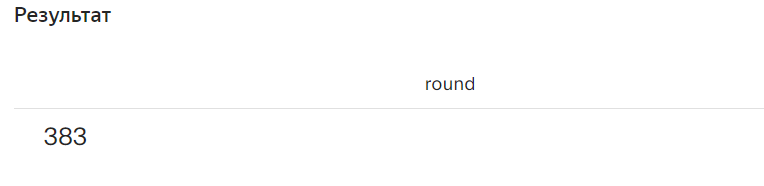

#### Задача 3

Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [ ]:
SELECT COUNT (DISTINCT u.id)
FROM stackoverflow.users u
JOIN stackoverflow.badges b ON u.id = b.user_id
WHERE b.creation_date::date = u.creation_date::date;

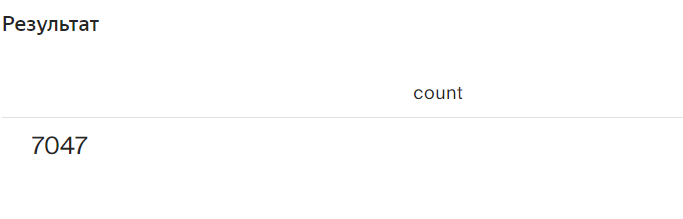

#### Задача 4

Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [ ]:
SELECT COUNT(DISTINCT p.id)
FROM stackoverflow.posts p
JOIN stackoverflow.users u ON p.user_id = u.id
JOIN stackoverflow.votes v ON p.id = v.post_id
WHERE u.display_name = 'Joel Coehoorn';

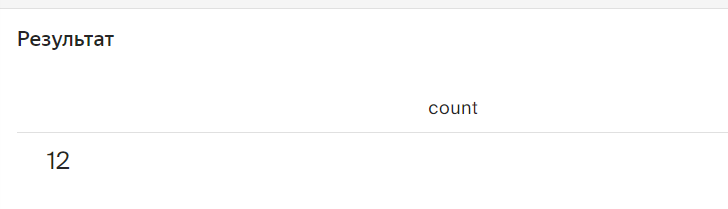

#### Задача 5

Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

In [ ]:
SELECT *,
       ROW_NUMBER () OVER (ORDER BY id DESC) as rank
FROM stackoverflow.vote_types
ORDER BY rank DESC;

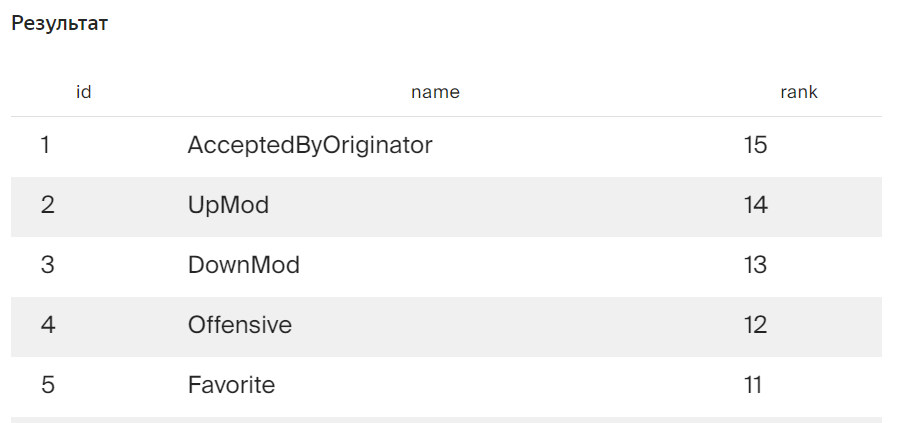

...

#### Задача 6

Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [ ]:
SELECT DISTINCT u.id,
       COUNT(vt.id)
FROM stackoverflow.users u
JOIN stackoverflow.votes v on u.id=v.user_id
JOIN stackoverflow.vote_types vt on v.vote_type_id = vt.id
WHERE vt.name = 'Close'
GROUP BY u.id
ORDER BY COUNT(vt.id) DESC,
        u.id DESC
LIMIT 10; 

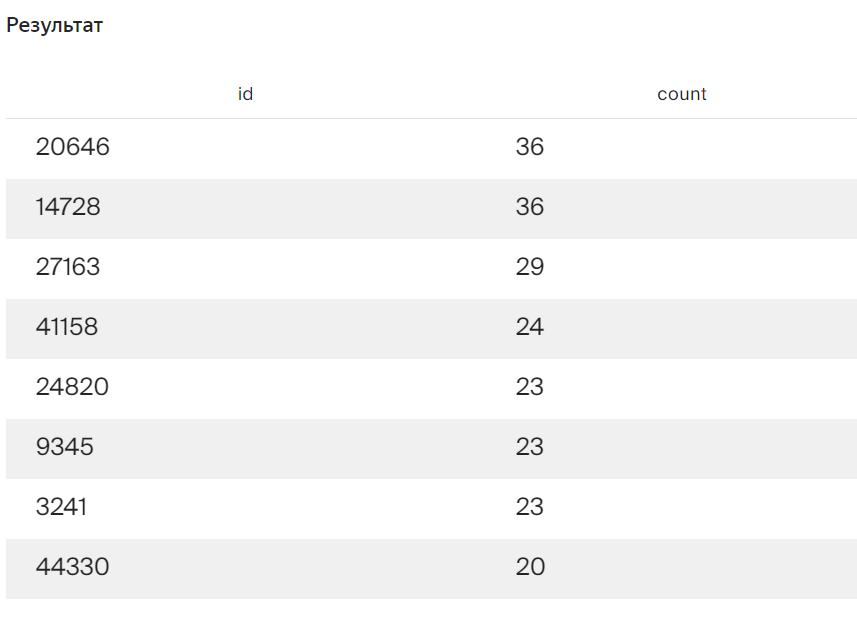

...

#### Задача 7

Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.

Отобразите несколько полей:
- идентификатор пользователя;
- число значков;
- место в рейтинге — чем больше значков, тем выше рейтинг.

Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.

Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [ ]:
SELECT u.id,
       COUNT(b.id),
       DENSE_RANK() OVER (ORDER BY COUNT(b.id) DESC)
FROM stackoverflow.users u
JOIN stackoverflow.badges b ON u.id = b.user_id
WHERE b.creation_date::date BETWEEN '2008-11-15' AND '2008-12-15'
GROUP by u.id
ORDER BY COUNT(b.id) DESC,
         u.id
LIMIT 10;

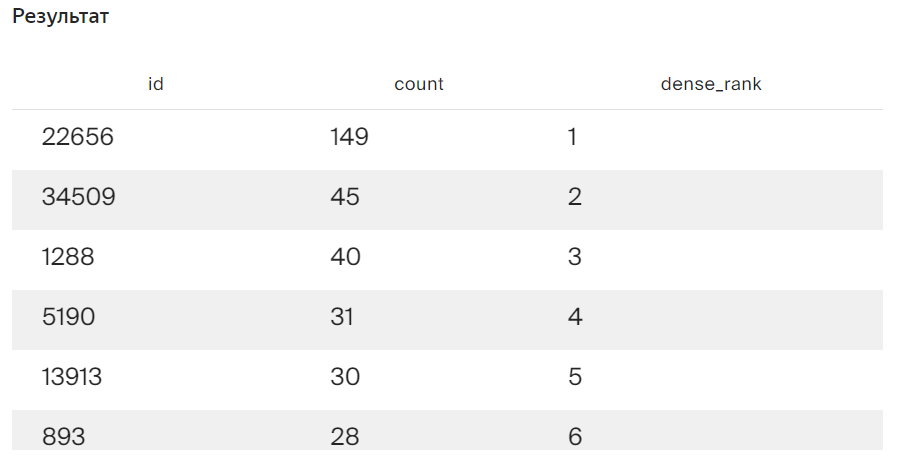

...

#### Задача 8

Сколько в среднем очков получает пост каждого пользователя?

Сформируйте таблицу из следующих полей:
- заголовок поста;
- идентификатор пользователя;
- число очков поста;
- среднее число очков пользователя за пост, округлённое до целого числа.

Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [ ]:
SELECT title,
       user_id,
       score,
       ROUND(AVG(score) OVER (PARTITION BY user_id))
FROM stackoverflow.posts
WHERE title IS NOT NULL 
      AND score != 0;

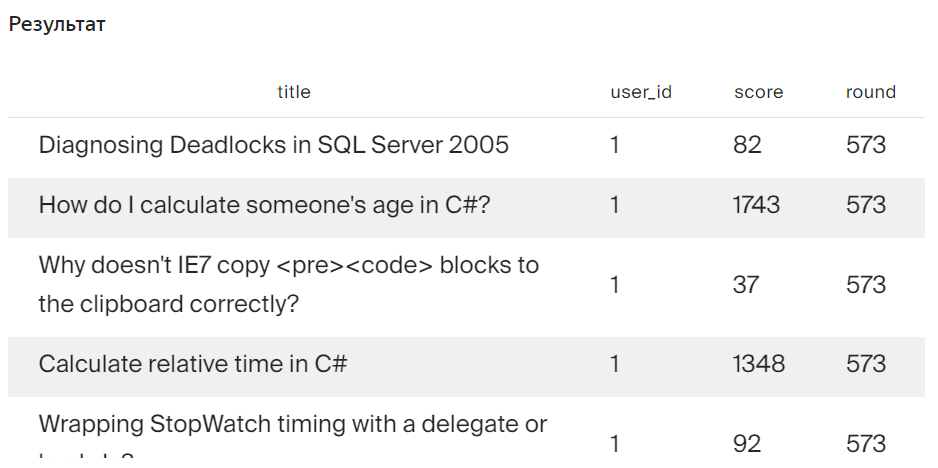

...

#### Задача 9

Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [ ]:
WITH user_with_b AS 
(SELECT u.id,
        COUNT(b.id)
 FROM stackoverflow.users u
 JOIN stackoverflow.badges b ON u.id=b.user_id
 GROUP BY u.id
 HAVING COUNT(b.id) > 1000)
SELECT p.title
FROM user_with_b
JOIN stackoverflow.posts p ON user_with_b.id = p.user_id
WHERE p.title IS NOT NULL;

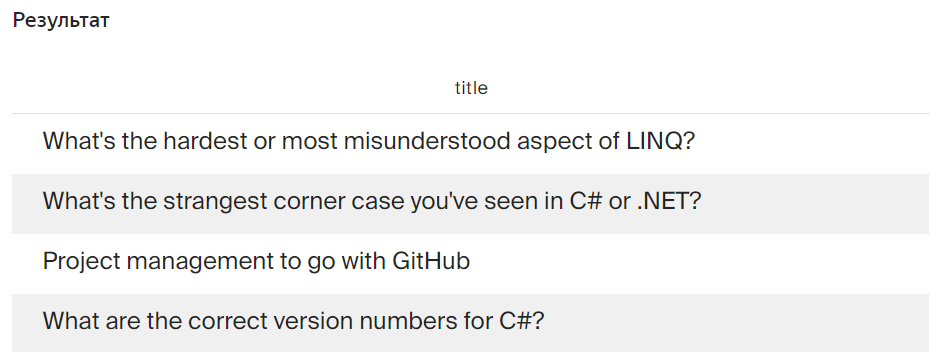

#### Задача 10

Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
- пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
- пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
- пользователям с числом просмотров меньше 100 — группу 3.

Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.

In [ ]:
SELECT DISTINCT id,
       views,
       CASE
           WHEN views >= 350 THEN 1
           WHEN views < 350 AND views >= 100 THEN 2
           WHEN views < 100 THEN 3
       END
FROM stackoverflow.users
WHERE views != 0
      AND location LIKE '%United States%';

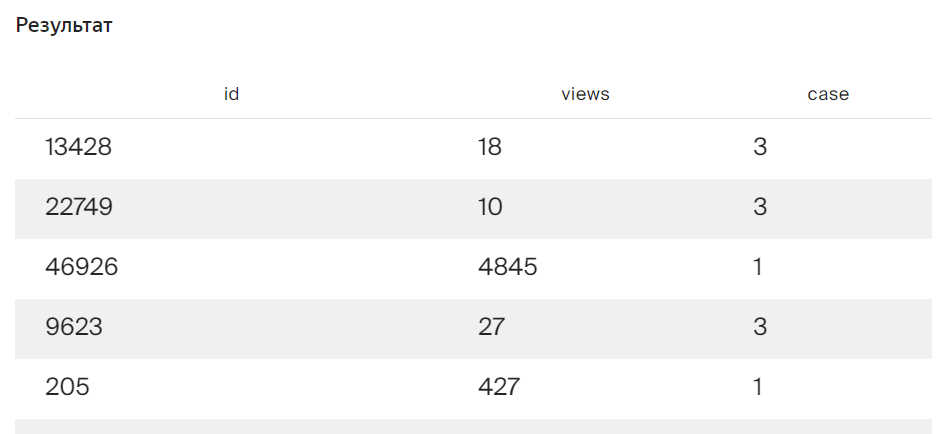

...

#### Задача 11 

Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [ ]:
WITH groups AS (SELECT DISTINCT id,
       views,
       CASE
           WHEN views >= 350 THEN 1
           WHEN views < 350 AND views >= 100 THEN 2
           WHEN views < 100 THEN 3
       END AS group_number
FROM stackoverflow.users
WHERE views != 0
      AND location LIKE '%United States%'),
groups2 AS 
(SELECT *, 
        MAX(views) OVER (PARTITION BY group_number) AS max_value
FROM groups)
SELECT id,
       group_number,
       views
FROM groups2
WHERE views=max_value
ORDER BY views DESC,
         id;

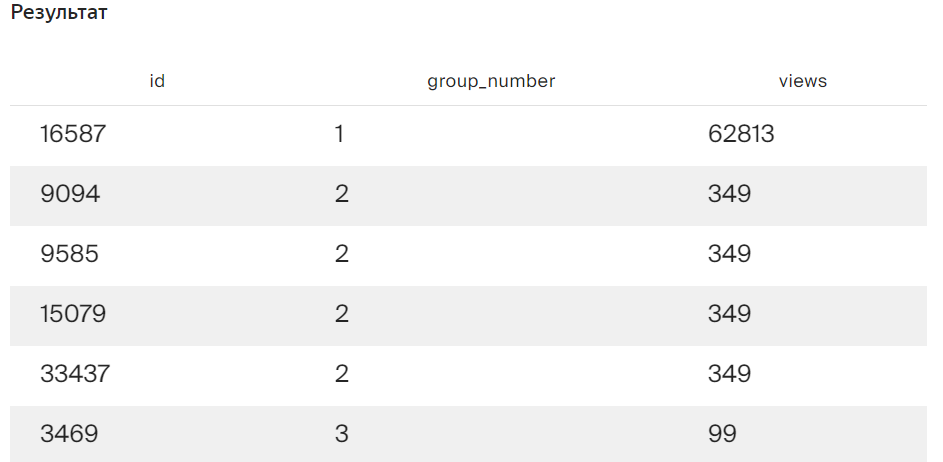
...

#### Задача 12 

Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
- номер дня;
- число пользователей, зарегистрированных в этот день;
- сумму пользователей с накоплением.

In [ ]:
SELECT EXTRACT(DAY FROM creation_date::DATE) AS day_reg,
       COUNT(id),
       SUM(COUNT(id)) OVER (ORDER BY EXTRACT(DAY FROM creation_date::DATE)) AS count_reg
FROM stackoverflow.users
WHERE creation_date::DATE BETWEEN '2008-11-01' AND '2008-11-30'
GROUP BY day_reg

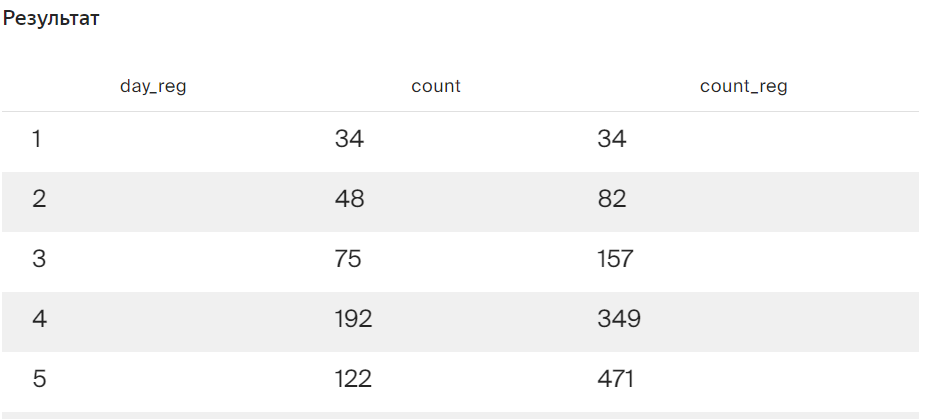
...

#### Задача 13

Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
- идентификатор пользователя;
- разницу во времени между регистрацией и первым постом.

In [ ]:
WITH posts1 AS (SELECT user_id,
       creation_date AS post_creation,
       ROW_NUMBER () OVER (PARTITION BY user_id ORDER BY creation_date) AS rn
FROM stackoverflow.posts)
SELECT u.id,
       posts1.post_creation - u.creation_date
FROM posts1
JOIN stackoverflow.users u on posts1.user_id = u.id
WHERE rn=1;

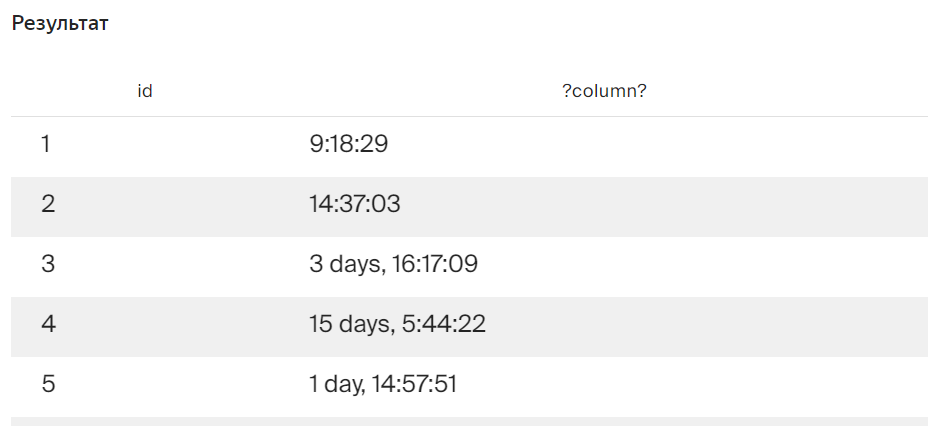
...

#### Задача 14 

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [ ]:
SELECT DATE_TRUNC('month', creation_date)::date,
       SUM(views_count)
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY SUM(views_count) DESC;

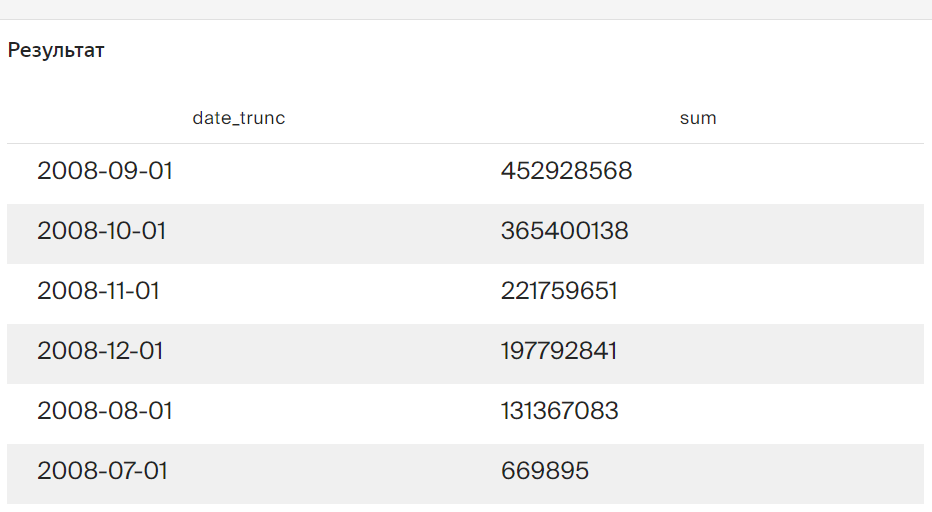
...

#### Задача 15

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [ ]:
SELECT COUNT(DISTINCT p.user_id), 
       u.display_name
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id=p.user_id
JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month') 
      AND pt.type LIKE '%Answer%'
GROUP BY u.display_name
HAVING COUNT(pt.id) > 100
ORDER BY u.display_name;

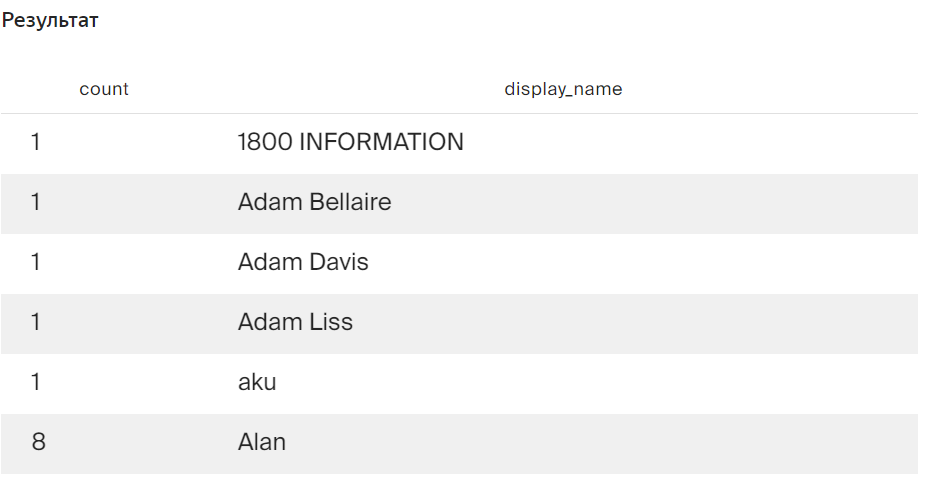
...

#### Задача 16

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [ ]:
SELECT DATE_TRUNC('month', creation_date)::date,
       COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN 
(SELECT u.id
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id=p.user_id
WHERE u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'
      AND p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY DATE_TRUNC('month', creation_date)::date DESC;

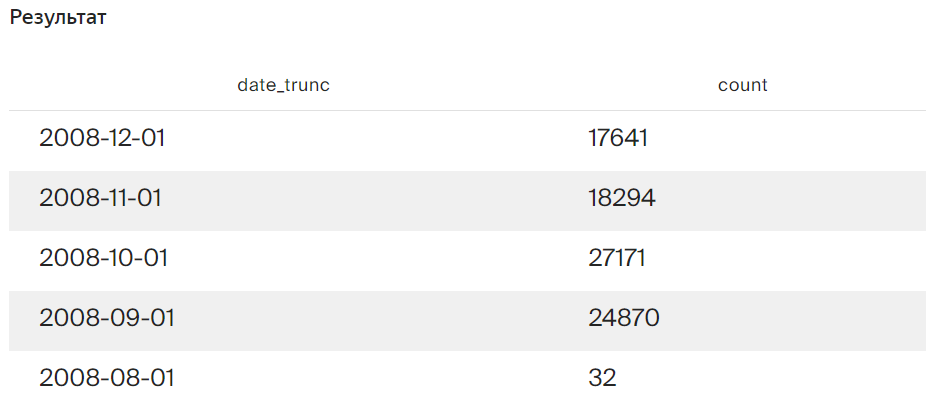

#### Задача 17

Используя данные о постах, выведите несколько полей:
- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [ ]:
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id,
         creation_date;

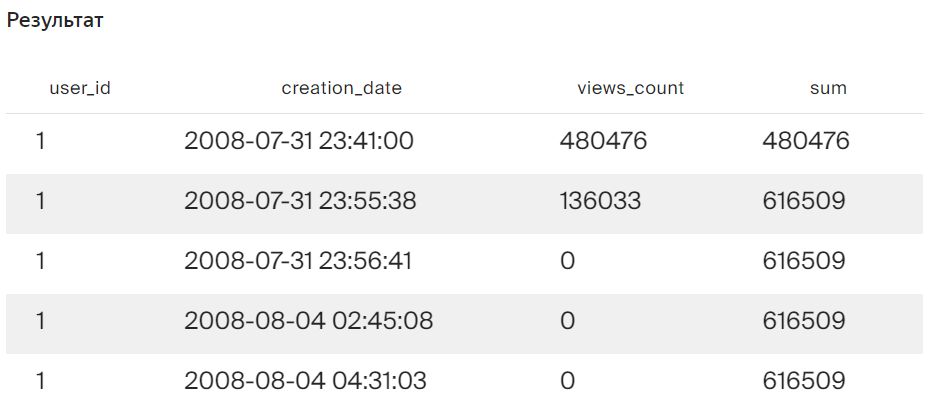
...

#### Задача 18

Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

In [ ]:
WITH active_days AS
(SELECT user_id,
        creation_date::date AS d,
       COUNT(creation_date::date) as days_cnt
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id, d)
SELECT ROUND(AVG(days_cnt))
FROM active_days;

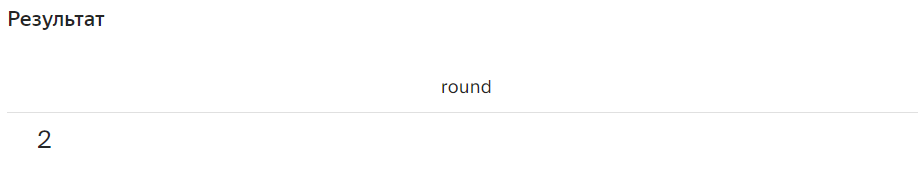

#### Задача 19

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:
- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [ ]:
SELECT *,
       ROUND((100 * CAST(posts_count AS NUMERIC) / LAG(posts_count, 1) OVER (ORDER BY posts_count DESC) - 100),2) AS percentage   
FROM (SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
             COUNT(id) AS posts_count
      FROM stackoverflow.posts 
      WHERE creation_date BETWEEN '2008-09-01' AND '2008-12-31'
      GROUP BY creation_month
      ORDER BY creation_month) AS foo

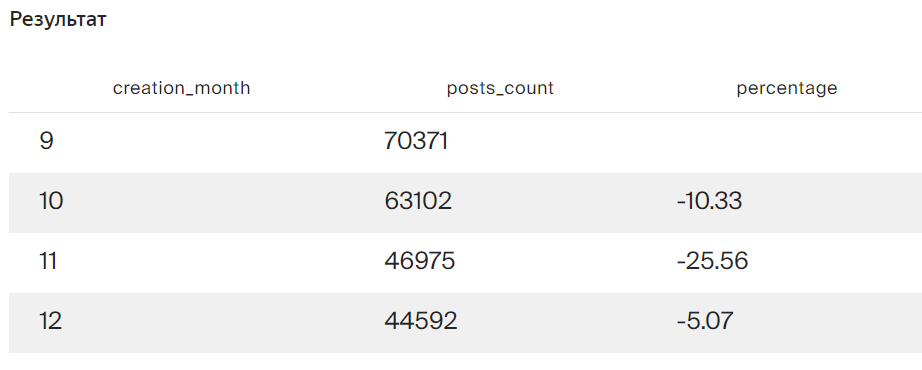

#### Задача 20

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:
- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [ ]:
WITH one_tab AS 
(SELECT posts.creation_date AS post_date,
        EXTRACT(WEEK FROM creation_date) AS week_number
            FROM stackoverflow.posts AS posts
            WHERE posts.user_id IN (SELECT posts.user_id
            FROM stackoverflow.posts AS posts       
            GROUP BY 1
            ORDER BY COUNT(posts.id) DESC
            LIMIT 1)
            AND posts.creation_date::DATE BETWEEN '2008-10-01' AND '2008-10-31' ORDER BY post_date)
            
SELECT DISTINCT week_number,
       LAST_VALUE (one_tab.post_date) OVER  (PARTITION BY week_number)
FROM one_tab
ORDER BY 1 ASC;

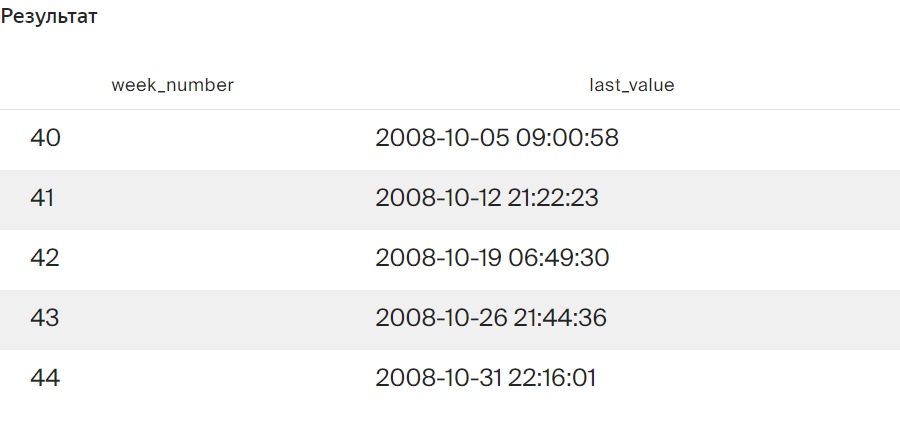